In [1]:
### cs109default ### 
import random
random.seed(112358)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline

import seaborn as sns
pd.set_option('display.width', 1500)
pd.set_option('display.max_columns', 100)

from scipy import signal
sns.set_context("talk")
sns.set_style("whitegrid", {"axes.facecolor": ".999"})
import pickle

,time,label,value,Unnamed: 3
0,1:08:48 PM,Heartrate,0,NaN
1,1:08:48 PM,Confidence,0,NaN
2,1:08:48 PM,Oxygen,0,NaN
3,1:08:48 PM,Status,0,NaN
4,1:08:48 PM,Extended Status,-3,NaN


,time,value
461,1:12:41 PM,52
471,1:12:46 PM,52
481,1:12:51 PM,52
491,1:12:56 PM,53
501,1:13:01 PM,53
511,1:13:06 PM,53
521,1:13:11 PM,53
531,1:13:16 PM,54
541,1:13:21 PM,54
551,1:13:26 PM,53


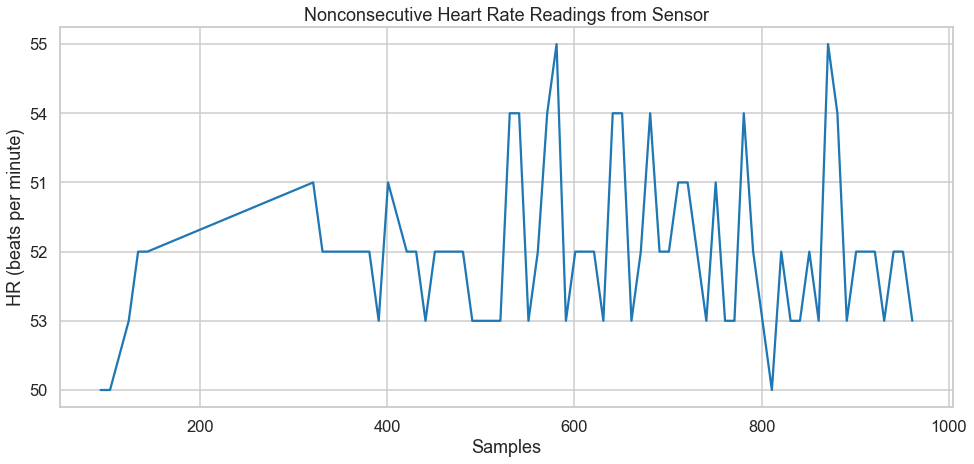

In [2]:
# preparing data
FILE = 'CAMILLES_1125_data.csv'

# reading in CSV file for sensor-calculated HR data
data_sensor_clh = pd.read_csv(FILE)
display(data_sensor_clh.head())

# removing unnecessary columns, reformatting
data_sensor_clh = data_sensor_clh.drop(columns = [str('Unnamed: 3')])
sensor_hr = data_sensor_clh.loc[data_sensor_clh['label'] == str(' Heartrate')].drop(columns = [str('label')])

# EDA
sensor_hr = sensor_hr.loc[(np.array(sensor_hr.value)!=str(0))]
fig, ax = plt.subplots(1,1, figsize = (16,7))
plt.plot(sensor_hr.value)
plt.title('Nonconsecutive Heart Rate Readings from Sensor')
plt.xlabel('Samples')
plt.ylabel('HR (beats per minute)')

# extracting consecutive (4-minute) reading
sensor_hr = sensor_hr.tail(51)
display(sensor_hr.head(10))
# reading in CSV file for blood volume pulse data (algorithm)

# # 5:13:58 PM, hours:minutes:seconds, dropping the first row (has sampling frequency)
# print("This is the sampling frequency in Hertz for the blood volume pulse (BVP) readings:",pd.read_csv("CHL_BVP_1124.csv").iloc[0][0])
sampling_rate_bvp = 64 # hertz, or samples per second
# bvp = pd.read_csv("CHL_BVP_1124.csv").iloc[1:]
# bvp.tail(10)

In [4]:
# find the samples that line up with 1:11:46 PM to 1:17:25 PM
# 1:08:48 PM is start

# 1. find 1:11:46 PM, which is 2 minutes and 58 seconds from when the first data was taken at 1:08:48 PM
to_528PM_bvp = int(sampling_rate_bvp*((2*60)+58))

# 2. find 5:32:30 PM, which is 4 minutes and 20 seconds from 5:28:10 PM
to_532PM_bvp = int(to_528PM_bvp + (sampling_rate_bvp*((4*60)+20)))

# checking to make sure the difference is 4 minutes and 20 seconds worth of data
print(str(((to_532PM_bvp-to_528PM_bvp)/sampling_rate_bvp)/60)+str(' minutes'))

# comparison = pd.DataFrame()
# comparison['sensor'] = sensor_hr(to_528PM_bvp:to_532PM_bvp)

4.333333333333333 minutes


# Exploratory Data Analysis of Blood Volume Pulse (BVP) Reading from E4 Band

In [5]:
# # visualization
# sample_bvp = bvp.iloc[to_528PM_bvp:to_532PM_bvp]

# fig, ax = plt.subplots(1,1, figsize = (16,7))
# plt.plot(sample_bvp)
# plt.xlabel('Samples')
# plt.ylabel('BVP Value')
# plt.title('Blood Volume Pulse (BVP) Samples');

The above graph shows the raw photoplethysmography data as taken from the Empatica E4 band. More on photoplethysmography below.

In [6]:
# create a function that reads in 5 second chunks of data, (optionally) finds the peaks in these five second chunks, and 
# outputs an approximate HR value


def chunks(array, n, peak_choice='Y'):
    '''
    function for dividing the detected peaks.
    array - the array to be divided
    n - number of samples per chunk (# seconds that you want to window * sampling frequency)
    '''
    subset = {}
    if peak_choice == 'Y':
        subset_int_hr = {}
        subset_float_hr = {}
    print(type(len(array)))
    for i, index in enumerate(range(0, len(array), n)):
        time_array = np.linspace(index/int(sampling_rate_bvp), ((index+n)/int(sampling_rate_bvp)), n)
        subset[str(i)] = np.array(array[index:index+n])
        if peak_choice == 'Y':
            indices = signal.find_peaks_cwt(subset[str(i)].reshape(320,), widths = np.ones(subset[str(i)].shape)*15)
            subset_int_hr[str(i)] = len(indices)*12 # to calculate heart rate in integer form
            subset_float_hr[str(i)] = np.round((len(indices)*60)/(np.abs(indices[0] - indices[-1])/sampling_rate_bvp),2)
            plt.scatter((indices/int(sampling_rate_bvp))+(index/int(sampling_rate_bvp)), subset[str(i)][indices], color = 'orange')
            plt.plot(time_array,subset[str(i)])
            plt.xlabel('Time (sec)')
            plt.ylabel('Value')
            plt.title('BVP over time: Chunk '+str(i))
            plt.show()
    if peak_choice == 'Y':
        return subset, subset_int_hr, subset_float_hr
    return subset

In [7]:
print(type(sampling_rate_bvp))
chunks_bvp, hr_from_bvp, hr_float_from_bvp = chunks(sample_bvp, int(5*sampling_rate_bvp))

<class 'int'>


NameError: name 'sample_bvp' is not defined

# 5 SECOND CHUNKS FROM EMPATICA

The previous graphs are 5-second representations of a consecutive 4 minute and 20 second blood volume pulse reading from an Empatica E4 Band [https://www.empatica.com/research/e4/]. This band uses photoplethysmography to find blood volume pulse (sampling frequency = 64 Hz). Photoplethysmography measures the absorption of light (red light) in blood, which varies with blood volume, a direct measure of pulse rate [https://www.ncbi.nlm.nih.gov/pubmed/17322588].

The function `find_peaks_cwt` returns the indices of the peaks of an inputted dataset. In the function `chunks`, `find_peaks_cwt` locates the peaks, equivalent to heart beats, in each 5-second subset of the original dataset and the variable `indices` stores this value. Heart rate in beats per minute is the product of the length of this array (in units of integer peaks/beats per 5 seconds) by 12. The number of peaks in these subsets range from 5 to 7, which results in heart rates of 60, 72, and 84 beats per minute.

`chunks` also returns a float interpretation of heart rate. In this approach, the indices of the peaks/beats represent the time between the total number of peaks/beats in that 5-second interval. After converting from number of samples to time, the quotient of the number of peaks/beats and the time between these peaks/beats is the number of heart beats per second, which represents heart rate in beats per minute once multiplied by 60 sec/min.

In [8]:
# playing with data
indices = signal.find_peaks_cwt(chunks_bvp[str(1)].reshape(320,), widths = np.ones(chunks_bvp[str(1)].shape)*10)
print("This is the shape of the array (with peak indices) returned by find_peaks_cwt:", chunks_bvp[str(1)][indices].shape)
plt.scatter(indices.reshape(-1,1), chunks_bvp[str(1)][indices])
plt.plot(chunks_bvp[str(1)]);

NameError: name 'chunks_bvp' is not defined

In [9]:
type(hr_float_from_bvp)

NameError: name 'hr_float_from_bvp' is not defined

In [10]:
# # dropping last five seconds of hr_from_bvp to make the data frames with peaks from my algorithm (hr_from_bvp) 
# # and sensor_hr
# print(len(hr_from_bvp), len(sensor_hr))
# hr_from_bvp_drop1 = pd.DataFrame.from_dict(hr_from_bvp,orient = 'index').iloc[0:51]
# hr_float_from_bvp = pd.DataFrame.from_dict(hr_float_from_bvp, orient = 'index')

# # ensuring lengths are the same
# print(str('Lengths ') + str(len(hr_from_bvp_drop1))+(', ')+str(len(sensor_hr)))
comparison = pd.DataFrame()
# comparison['algorithm'] = hr_from_bvp_drop1[0]
# comparison['algorithm_float'] = pd.DataFrame.from_dict(hr_float_from_bvp)
comparison['sensor'] = (np.array(sensor_hr.value, dtype = int))
len(comparison)

51

In [11]:
# # comparison of calculated HR versus band HR versus finger sensor
# # fig, ax = plt.subplots(2,1, figsize = (16,7))
# # ax[0].scatter(np.arange(len(hr_from_bvp_drop1)), hr_from_bvp_drop1)
# # ax[0].scatter(np.arange(len(sensor_hr)), sensor_hr.value)


# fig,ax = plt.subplots(1,1, figsize = (16,7))

# ax.scatter(np.linspace(0, len(comparison)*5, len(comparison)), comparison.algorithm, c='b', marker="s", label='Algorithm')
# ax.scatter(np.linspace(0, len(comparison)*5, len(comparison)), comparison.algorithm_float, c='orange', marker="*", label='Algorithm2')
# ax.scatter(np.linspace(0, len(comparison)*5, len(comparison)), comparison.sensor, c='r', marker="o", label='Sensor')
# plt.legend(loc='upper left')
# plt.xlabel('Time (sec)')
# plt.ylabel('Heart Rate (beats per minute)')
# plt.title('Comparison of Heart Rate Measured by Algorithm and Sensor')
# plt.show()

# COMPARISON OF SENSOR HEART RATE AND 2 ALGORITHMS

The x-axis represents the 5-second subsets in time (seconds) and the y-axis represents the value of heart rate when acquired by the Sparkfun sensor, the first peak finder algorithm, and the second peak finder algorithm.

In [12]:
FILE2 = 'CS_HR_1125.csv'
hr_from_band = pd.read_csv(FILE2)
hr_from_band

,1574704613
0,1.00
1,58.00
2,57.00
3,55.67
4,54.75
...,...
1228,58.53
1229,58.80
1230,59.02
1231,59.25


In [13]:
# start time 12:56:53, data collection wanted from 1:11:46 PM to 1:17:25 PM
sampling_rate_hr = 1 # Hz

# find the samples that line up with 1:11:46 PM to 1:17:25 PM

# 1. find 1:11:46 PM, which is 14 minutes and 53 seconds from when the first data was taken
to_528PM_hr = sampling_rate_hr*((14*60)+53) 
print(to_528PM_hr)

# 2. find 5:32:30 PM, which is 4 minutes and 20 seconds from 5:28:10 PM
to_532PM_hr = to_528PM_hr + (sampling_rate_hr*((4*60)+20))
print(to_532PM_hr)

# checking to make sure the difference is 4 minutes and 20 seconds worth of data
print(((to_532PM_hr-to_528PM_hr)/sampling_rate_hr)/60)
print(to_532PM_hr-to_528PM_hr)

893
1153
4.333333333333333
260


,1574704613
1,58.00
2,57.00
3,55.67
4,54.75
5,54.20
...,...
1228,58.53
1229,58.80
1230,59.02
1231,59.25


,1574704613
894,52.07
899,52.57
904,52.78
909,52.77
914,52.72
919,52.75
924,52.92
929,53.07
934,53.57
939,54.07


<class 'pandas.core.series.Series'>


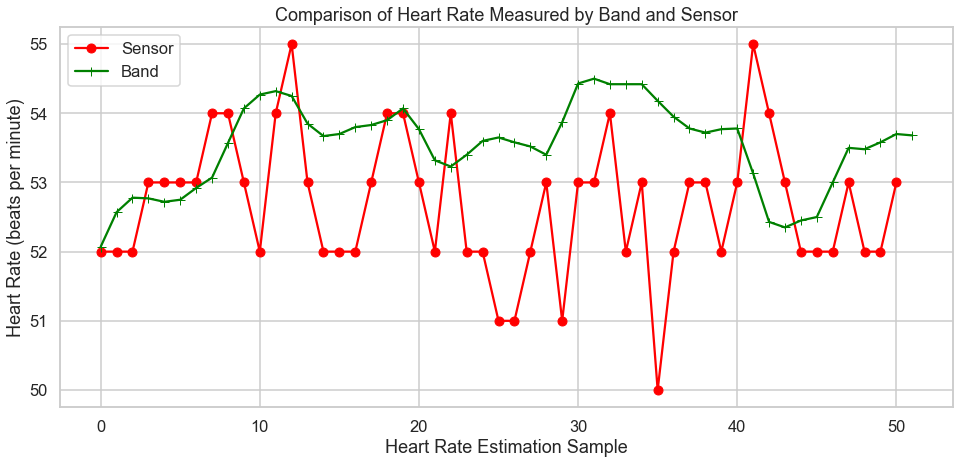

In [14]:
# dropping first row (contains the sampling frequency)
hr_from_band = hr_from_band.iloc[1:]
display(hr_from_band)

band_four_min = hr_from_band.iloc[to_528PM_hr:to_532PM_hr]
time_hr = np.linspace(0, len(comparison), len(band_four_min[::5]))

fig,ax = plt.subplots(1,1, figsize = (16,7))

# ax.scatter(np.arange(len(comparison)), comparison.algorithm, c='b', marker="s", label='Algorithm')
ax.plot(np.arange(len(comparison)), comparison.sensor, c='r', marker="o", label='Sensor')
ax.plot(time_hr, band_four_min[::5], c='green', marker="+", label='Band');
plt.legend(loc='upper left')
plt.xlabel('Heart Rate Estimation Sample')
plt.ylabel('Heart Rate (beats per minute)')
plt.title('Comparison of Heart Rate Measured by Band and Sensor')
fig1 = plt.gcf()
fig1.savefig('CS_HR from Band vs HR from Sensor.png')
comparison['band'] = band_four_min[::5]
display(band_four_min[::5])
pickle.dump(comparison.sensor, open(str('CS_sensor.p'), 'wb'))
print(type(comparison.sensor))
# comparison['CS_band'] = band_four_min[::5]
# band_values = (band_four_min[::5])
# print(type(band_values))
pickle.dump(band_four_min[::5], open(str('CS_band.p'), 'wb'))

In [27]:
pickle.dump(comparison, open(str('CS_comparison.p'), 'wb'))

      1574704613
894        52.07
895        52.03
896        52.17
897        52.30
898        52.43
...          ...
1149       53.68
1150       53.68
1151       53.68
1152       53.68
1153       53.70

[260 rows x 1 columns]


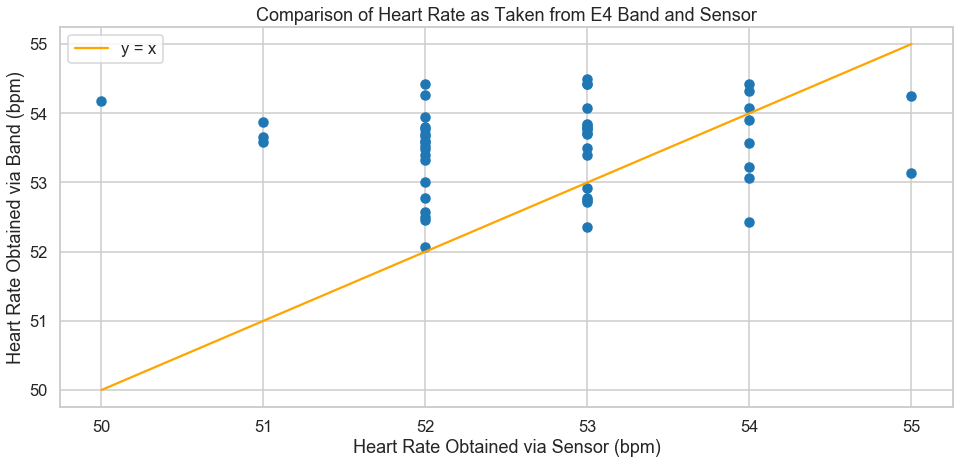

In [16]:
# plotting accuracy of heart rate between sensor and band (every fifth value)
fig, ax = plt.subplots(1,1, figsize = (16,7))
plt.scatter(comparison.sensor, band_four_min.iloc[0:255][::5])
plt.plot(np.linspace(comparison.sensor.min(), comparison.sensor.max()), np.linspace(comparison.sensor.min(), comparison.sensor.max()), color = 'orange', label = 'y = x')
plt.xlabel('Heart Rate Obtained via Sensor (bpm)')
plt.ylabel('Heart Rate Obtained via Band (bpm)')
plt.legend()
plt.title('Comparison of Heart Rate as Taken from E4 Band and Sensor');

In [26]:
len(band_four_min), len(comparison)

(260, 51)

In [17]:
five_average_window_hr = []
results_hr = chunks(band_four_min.iloc[0:255], 5, peak_choice='N')
for each in results_hr:
    five_average_window_hr.append(np.mean(results_hr[each]))
comparison['moving_average_5_band'] = five_average_window_hr

<class 'int'>


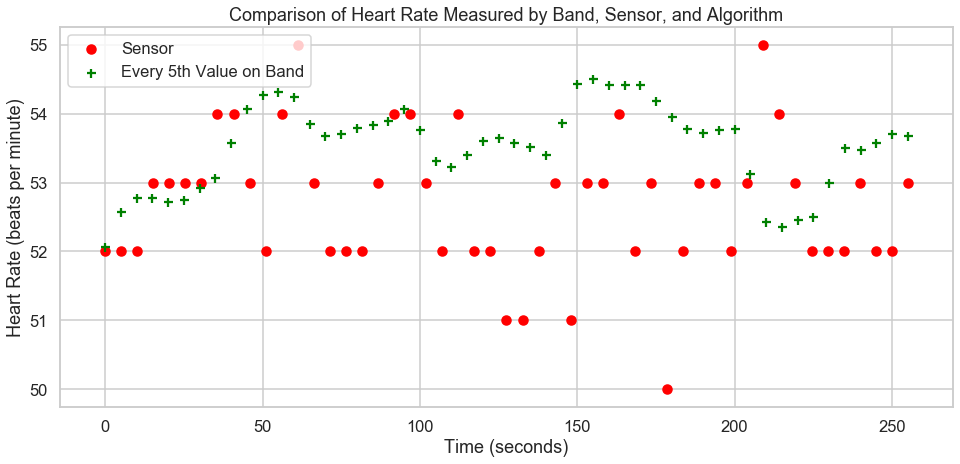

In [18]:
comparison['every_fifth_band'] = np.array(band_four_min.iloc[0:255][::5], dtype = float)

band_four_min = hr_from_band.iloc[to_528PM_hr:to_532PM_hr]
time_hr = np.linspace(0, len(comparison)*5, len(band_four_min[::5]))
time_rolling = np.linspace(0, len(comparison.sensor)*5, len(comparison.moving_average_5_band))

fig,ax = plt.subplots(1,1, figsize = (16,7))

# ax.scatter(time_rolling, comparison.algorithm, c='b', marker="s", label='Algorithm')
ax.scatter(time_rolling, comparison.sensor, c='r', marker="o", label='Sensor')
ax.scatter(time_hr, band_four_min[::5], c='green', marker="+", label='Every 5th Value on Band');
# ax.scatter(time_rolling, comparison.moving_average_5_band, c='purple', marker="*", label='Moving Average on Band');
plt.legend(loc='upper left')
plt.xlabel('Time (seconds)')
plt.ylabel('Heart Rate (beats per minute)')
plt.title('Comparison of Heart Rate Measured by Band, Sensor, and Algorithm')
plt.show()

In [19]:
comparison['stdev_sensor_band'] = np.std(comparison[['every_fifth_band','sensor']], axis = 1)
comparison['mean_sensor_band'] = np.mean(comparison[['every_fifth_band','sensor']], axis = 1)
comparison

,sensor,band,moving_average_5_band,every_fifth_band,stdev_sensor_band,mean_sensor_band
0,52,NaN,52.200,52.07,0.035,52.035
1,52,NaN,52.708,52.57,0.285,52.285
2,52,NaN,52.772,52.78,0.390,52.390
3,53,NaN,52.748,52.77,0.115,52.885
4,53,NaN,52.722,52.72,0.140,52.860
5,53,NaN,52.810,52.75,0.125,52.875
6,53,NaN,52.984,52.92,0.040,52.960
7,54,NaN,53.258,53.07,0.465,53.535
8,54,NaN,53.768,53.57,0.215,53.785
9,53,NaN,54.176,54.07,0.535,53.535


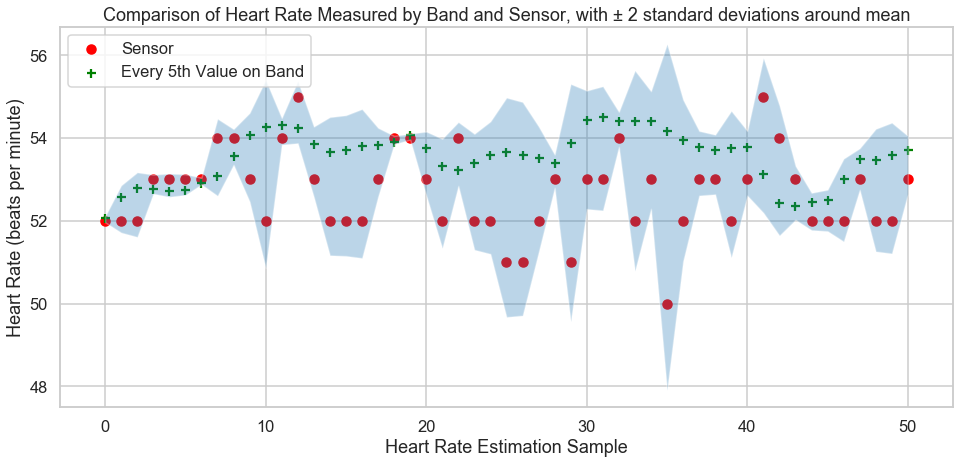

In [20]:
fig,ax = plt.subplots(1,1, figsize = (16,7))

ax.scatter(np.arange(len(comparison)), comparison.sensor, c='r', marker="o", label='Sensor')
ax.scatter(np.arange(len(comparison)), comparison.every_fifth_band, c='green', marker="+", label='Every 5th Value on Band')
ax.fill_between(np.arange(len(comparison)), (comparison.mean_sensor_band - (2*comparison.stdev_sensor_band)), comparison.mean_sensor_band + (2*comparison.stdev_sensor_band), alpha = 0.3)
plt.legend(loc='upper left')
plt.xlabel('Heart Rate Estimation Sample')
plt.ylabel('Heart Rate (beats per minute)')
plt.title('Comparison of Heart Rate Measured by Band and Sensor, with ± 2 standard deviations around mean')
plt.show()